<img src="images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Linear Regression &mdash; Assumptions & Caveats

From a purely algorithmic point of view, a Linear Regression can be trained on any data representing a supervised regression task. However, the introductory notebook also indicated that the model relies on certain assumptions that must hold to ensure the validity of the model's predictions and inferences. If the assumptions are violated, the model's outputs may be unreliable or misleading. Most fundamentally, the Linear Regression assume that there exists indeed a (sufficiently prominent) relationship between the input features $\mathbf{x}_i$ and the target variable $y_i$, which was described by the following equation

$$\large
y_i = w_{0} + w_{1}x_{i1} + w_{2}x_{i2} + w_{3}x_{i3} + \dots + w_{d}x_{id} + e_{i}
$$

for the $i$-th training data sample. We also already saw that the models assume that the expectation value for the noise terms $E(e_i) = 0$, i.e., that the noise terms, on average, cancel out.

In this notebook, we cover in more detail all fundamental assumptions a Linear Regression model makes, and how we can check this assumption before training a model. Keep in mind that often not all the assumptions will (perfectly) hold in practice. Minor violations may still allow the model to perform reasonably well but might require additional adjustments (e.g., data transformations steps). However, major violations may necessitate a different modeling approach beyond Linear Regression.

#### Preface: Time Series Data vs Cross-Sectional Data

The likelihood of an assumption of a Linear Regression model to be (severely) violated depends on the nature of the data. We can distinguish between two types of data. One the hand, **time series data** focuses on observations of a single subject or variable at different times usually at uniform intervals. It is the data of the same variable over a period of time such as hours, days, months, etc. The time series data takes the form of $\mathbf{x}_t$, $\mathbf{x}$ to represent the feature vector and $t$ the time. A typical example of time series data is the price of a stock. Here, $\mathbf{x}_t$ may be the feature vector containing the [Open-High-Low-Close (OHLC) Chart](https://en.wikipedia.org/wiki/Open-high-low-close_chart) data for a day $t$. Time series data is typically unidimensional considering only one subject (e.g., the price of a stock) over time.

On the other hand, **cross-sectional data** refers to data that captures information about multiple subjects at a specific point in time or within a short, non-repetitive time frame. This data does not account for temporal changes; instead, it provides a snapshot of the variables of interest at a single moment. The dataset of resale transactions of apartments within a single year we used in the introductory notebook is a typical example. Here, $\mathbf{x}_i$ and $\mathbf{x}_j$ represent two independent feature vectors for two different transactions in the dataset.

In this notebook, we focus on cross-sectional data as it is more common for regression tasks in machine learning. This includes that we focus on the assumptions and their violations that are more relevant for cross-sectional data. For example, some assumptions do almost always hold for cross-sectional data and are much more likely to be violated in the case of time series data.


**Note:** Apart from time series data and cross-sectional data, there is also **panel data** which represents a combination of time series and cross-sectional data.


### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
from src.utils.libimports.linreg import *
from src.utils.plotting.linreg import *
from src.utils.data.files import *

#### Download Required Data

Some code examples in this notebook use data that first need to be downloaded by running the code cell below. If this code cell throws any error, please check the configuration file `config.yaml` if the URL for downloading datasets is up to date and matches the one on Github. If not, simply download or pull the latest version from Github.

In [2]:
demo_data_basic, _     = download_dataset("tabular/resources/linreg-demo-data-basic.csv")
demo_data_multicoll, _ = download_dataset("tabular/resources/linreg-demo-data-multicollinearity.csv")

File 'data/datasets/tabular/resources/linreg-demo-data-basic.csv' already exists (use 'overwrite=True' to overwrite it).
File 'data/datasets/tabular/resources/linreg-demo-data-multicollinearity.csv' already exists (use 'overwrite=True' to overwrite it).


---

## Motivation: Anscombe's Quartet

Anscombe's Quartet is a set of four distinct datasets that have nearly identical statistical properties but appear very different when graphed. It was created by the statistician Francis Anscombe in 1973 to demonstrate the importance of graphing data before analyzing it and to show that relying solely on summary statistics can be misleading. Each dataset in the quartet has almost the same:

* Mean of the x-values and y-values.
* Variance of the x-values and y-values.
* Correlation between x and y (around 0.816).
* **Linear regression line: $y = 3 + 0.5x$.**
* Coefficient of determination (R^2 ≈ 0.67).

### Create & Plot Datasets

Let's create these first dataset so we can plot and train a Linear Regression model on them. The data is directly taken from the [Wikipedia page](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) about Anscombe's Quartet.

In [3]:
x_anscombe = np.asarray([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y_anscombe1 = np.asarray([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
y_anscombe2 = np.asarray([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
y_anscombe3 = np.asarray([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x_anscombe4 = np.asarray([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y_anscombe4 = np.asarray([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89])

datasets = {
    '1': (x_anscombe, y_anscombe1),
    '2': (x_anscombe, y_anscombe2),
    '3': (x_anscombe, y_anscombe3),
    '4': (x_anscombe4, y_anscombe4)
}

Let's plot the four dataset. For this, we provide you with an auxiliary method `plot_anscombes_quartet()`. Apart from plotting the different data points, this method also computes the mean $\mu$, the standard deviation $\sigma$ and the correlation coefficient $r$, and displays their values in the respective plots.

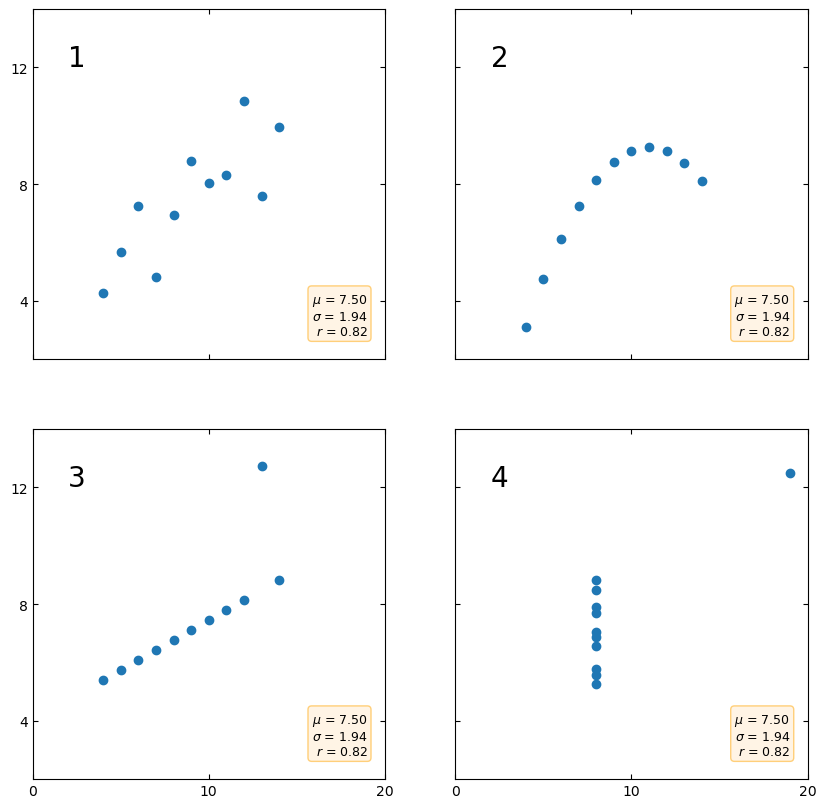

In [4]:
plot_anscombes_quartet(datasets, show_regression_line=False)

Just by looking at the four different distributions, the four dataset differ significantly. However, notice that all means, standard deviations, and correlation coefficients are identical (at least, for that given precision).

### Fit Linear Regression Models

The initial description of Anscombe's Quartet also states that all datasets have the same regression line $y = 3 + 0.5x$. So let's check this by training a Linear Regression over each of the four datasets using the `sklearn.linear_model.LinearRegression`] implementation of Linear Regression.

In [5]:
for (label, (x, y)) in datasets.items():
    # Fit Linear Regression model for current dataset
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    # Print model parameters: bias/intercept (w0) and slope (w1)
    print(f"Model parameters for Dataset {label}: w0={model.intercept_:.2f}, w1={model.coef_[0]:.2f}")
    

Model parameters for Dataset 1: w0=3.00, w1=0.50
Model parameters for Dataset 2: w0=3.00, w1=0.50
Model parameters for Dataset 3: w0=3.00, w1=0.50
Model parameters for Dataset 4: w0=3.00, w1=0.50


The results confirm that all four datasets have the same regression line $y = 3 + 0.5x$, where $w_0 = 3$ and $w_1 = 0.5$. We can also plot all four datasets again, but this time include the regression line in each plot.

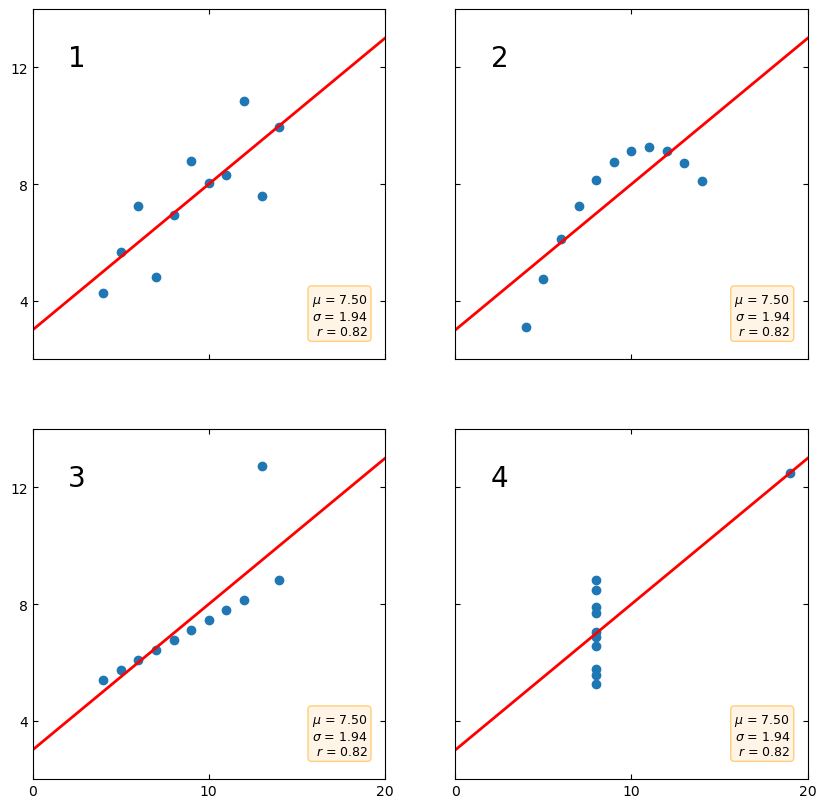

In [6]:
plot_anscombes_quartet(datasets, show_regression_line=True)

### Anscombe's Quartet: Summary

Anscombe's Quartet provides important lessons about the limitations and risks of training a linear regression model on a dataset without proper exploration and visualization. Here's what Anscombe's Quartet teaches us about this process:

* **Statistical summaries alone can be misleading:** Even when datasets have identical summary statistics (mean, variance, correlation, regression line), they can represent very different underlying relationships. Relying solely on numerical measures like correlation or $R^2$ values without visualizing the data can lead to incorrect conclusions about the model's accuracy or appropriateness. You might think a linear model fits well, but in reality, the true relationship could be non-linear or heavily influenced by outliers.

* **Visualizing the data is crucial:** Graphical representations can reveal patterns, trends, and anomalies (e.g., outliers, non-linear relationships) that summary statistics alone cannot detect. Before training a linear regression model, it is essential to visualize the data (e.g., using scatterplots). This can help determine whether a linear relationship exists or whether other relationships (curvilinear, exponential, etc.) or factors (outliers) need to be accounted for.

* **Model appropriateness:** The data in Anscombe's Quartet shows that different types of relationships (e.g., linear, non-linear, or one driven by an outlier) can produce similar regression results but are inappropriate for a linear model. It is important to assess whether a linear model is the right choice for the data. Anscombe's Quartet illustrates how, in some cases, a non-linear model may be more suitable, and a linear regression model could give misleading results if the data does not follow a linear pattern.

* **Outliers can significantly impact models:** In one dataset of Anscombe’s Quartet, a single outlier drastically changes the regression line, even though the overall statistics remain unchanged. Outliers can heavily influence linear regression models, leading to biased estimates of the regression coefficients. It is important to detect and consider removing or adjusting for outliers to avoid skewing the results.

* **Residual analysis is essential:** Checking residuals (the difference between observed and predicted values) can help in identifying whether a model is appropriate. A thorough analysis of the residuals can reveal patterns like non-linearity or heteroscedasticity (non-constant variance of residuals), which could indicate the model is not well-suited for the data. Anscombe’s Quartet shows that similar summary statistics can still result in very different residual patterns.

In short, Anscombe's Quartet emphasizes the need for deeper exploratory analysis, visualization, and validation when training any linear regression model. In the following, we want to delve deeper into the assumption of Linear Regression models, how can we test a given dataset to see if these assumptions hold.

---

## Assumptions

Through this section, we will use some demo data to see how we can check for violations of any assumptions. The code cell below loads this demo data into a pandas DataFrame for later use.

In [7]:
df = pd.read_csv(demo_data_basic)

df.head()

,x1,y1,x2,y2,x3,y3,x4,y4
0,1.000000,57.792157,1.000000,9.921570,1.000000,54.264052,1.000000,52.761631
1,1.018036,53.745562,1.018036,-31.715100,1.018036,52.952465,1.018036,51.805231
2,1.036072,55.526394,1.036072,-15.074240,1.036072,53.604224,1.036072,51.250539
3,1.054108,59.357950,1.054108,22.077106,1.054108,54.997414,1.054108,50.924701
4,1.072144,58.283035,1.072144,10.166992,1.072144,54.682652,1.072144,50.280927


### Assumption 1 (A1): Linearity

#### Definition

Linear Regression assumes that the *true* underlying relationship between the dependent variable (or target variable, or output) $y$ and the independent variables (or features, or attributes) $X$ is (mostly) linear in the parameters $\mathbf{w}$. Recall, this is given by that basic equation of a Linear Regression model:

$$\large
y_i = h(\mathbf{x}_i;\mathbf{w}) = w_{0} + w_{1}x_{i1} + w_{2}x_{i2} + \dots + w_{d}x_{id} + e_{i}
$$

In other words, the value of $y_i$ derives from a *linear* transformation $h(\mathbf{x}_i)$ from the features $x_{i1}$, ... $x_{id}$; $x_{i0}$ is our constant feature with $x_{i0}=1$.

**Important:** Note that the true relationship should be linear in the weights $\mathbf{w}$, not in the feature vector $x$. For example, this means that the models that have feature values raised to an exponent (e.g., $x_{1}^{2}$, $x_{2}^{3}$), do not violate the linearity assumption. This results in the concept of *Polynomial Linear Regression*; see separate notebooks for more details.

#### Checking the Assumption

There are different ways to check linearity in linear regression, but one of the most common and simple methods is to use scatter plots. A scatter plot is a graphical representation of the relationship between two variables, where each point represents an observation. To check linearity, you can plot the dependent variable against each independent variable, and look for a clear and consistent pattern. Ideally, you should see a straight line or a cloud of points that is roughly symmetrical around a straight line. If you see a curved or wavy pattern, or a cluster of points that is not evenly distributed, then you may have a nonlinear relationship.

Let's first look at an example of a very prominent linear relationship, using the two columns `x1` and `x2` from the DataFrame with demo data.

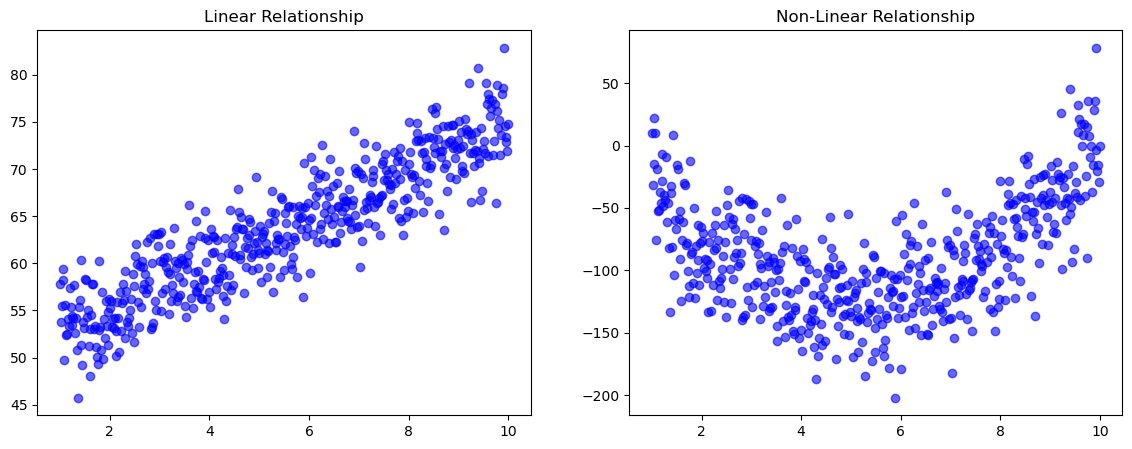

In [8]:
x1, y1 = df['x1'].to_numpy(), df['y1'].to_numpy()
x2, y2 = df['x2'].to_numpy(), df['y2'].to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 5))
ax1.scatter(x1, y1, color='blue', alpha=0.6, label='Data points')
ax2.scatter(x2, y2, color='blue', alpha=0.6, label='Data points')
ax1.set_title("Linear Relationship")
ax2.set_title("Non-Linear Relationship")
plt.show()

Another way to assess the strength of a linear relationship between to variable &mdash; here an input feature and the target output &mdash; is to calculate the **Pearson correlation coefficient** between these two variables. The [Pearson correlation coefficient](Pearson_correlation_coefficient), typically denoted by $r$, is a statistical measure that quantifies the strength and direction of a linear relationship between two variables $x$ and $y$, and is defined as:

$$\large
r = \frac{\sum_{i=1}^{n} \left( x_i - \bar{x} \right) \left( y_i - \bar{y} \right)}{\sqrt{\sum_{i=1}^{n} \left( x_i - \bar{x} \right)^2} \sqrt{\sum_{i=1}^{n} \left( y_i - \bar{y} \right)^2}}
$$

where $x_i$ and $y_i$ are data points of variables $x$ and $y$, respectively. $bar{x}$ and $\bar{y}$ are the mean (average) values of $x$ and $y$, respectively. Lastly, $n$ is the total number of data points. The range of $r$ is $-1 \leq r \leq +1$, where

* $r=1$ represents a perfect positive linear relationship; as one variable increases, the other increases in a perfectly linear fashion.
* $0 < r < 1$ indicates a positive linear relationship; higher values indicate stronger correlation.
* $r=0$ means there is no linear relationship between the two variables.
* $-1 < r < 0$ indicates a negative linear relationship; higher absolute values indicate stronger correlation.
* $r=−1$ represents a perfect negative linear relationship; as one variable increases, the other decreases in a perfectly linear fashion.

The (absolute) values of $r$ are generally interpreted as follows

* $0.7$ to $1.0$ (or $-0.7$ to $-1.0$): Strong positive (or negative) correlation.
* $0.3$ to $0.7$ (or $-0.3$ to $-0.7$): Moderate positive (or negative) correlation.
* $0.0$ to $0.3$ (or $-0.0$ to $-0.3$): Weak positive (or negative) correlation.

Let's calculate the correlation coefficients for the two demo dataset from the scatter plots above. For this, we can use an existing method provided by NumPy. The `corrcoef()` method is used to calculate the Pearson correlation coefficients between variables. It computes the correlation matrix, a square matrix that shows the correlation coefficients between multiple variables or datasets.

We first consider the dataset where the scatter plot told us that data exhibits a clear linear relationship:

In [9]:
print(np.corrcoef(x1, y1))

[[1.         0.90402285]
 [0.90402285 1.        ]]


Notice that the result is a $2\times 2$ matrix containing the correlation coefficients between all combinations of `x1` and `y1`. The two entries in the diagonal reflect the correlation between `x1` and `x1`, as well as be `y1` and `y1`. Naturally, the correlation between variables with itself will always yield a perfect linear correlation of $r=1$. The non-diagonal entries are the $r$ values between `x1` and `y1`, and vice versa. Since the calculation of the Pearson correlation coefficient is symmetric, both values are the same. With a value of $r=0.9$, `x1` and `y1` show a strong positive correlation, as expected from the scatter plot.

Now the same calculation for `x2` and `y2`:

In [10]:
print(np.corrcoef(x2, y2))

[[1.         0.24524613]
 [0.24524613 1.        ]]


According to the definitions above, `x2` and `y2` show a weak positive correlation with a correlation coefficient of $r=0.25$. The reason for the value not being closer to $0$ is that the non-linear relationship between `x2` and `y2` is not symmetric (cf., the corresponding scatter plot above). While the correlation coefficient is easy to compute and yields a simple value as a result, it can be challenging to interpret in practice, as it does not capture as much information as a scatter plot. In short, a scatter plot generally provides more expressive information about whether two variables have (strong or weak) linear relationship.

To sum up, when aiming to train a Linear Regression model over a dataset, we want to make sure that many to most input features show a reasonably strong linear relationship. Common approaches to check this are visualizing the relationships using scatter plots and/or the calculation of the pairwise correlation coefficients between each input feature and the target variable.

### Assumption 2 (A2): Normality and Homoscedasticity

#### Definition

In Linear Regression, normality and homoscedasticity are two key assumptions that ensure the validity of statistical inferences about the model. These assumptions pertain to the residuals (errors), which are the differences between observed and predicted values.

* The **normality assumption** states that the residuals should be normally distributed. This means the errors should form a bell-shaped curve when plotted, with most values concentrated near zero and fewer values further away. If the residuals deviate significantly from normality, it may indicate issues such as outliers, skewness, or missing variables in the model.

* The **homoscedasticity assumption** requires that the residuals have constant variance across all levels of the independent variables. In other words, the spread (or scatter) of the residuals should remain roughly the same regardless of the predicted values or the values of the independent variables. Violations of this assumption, known as heteroscedasticity, can lead to inefficient estimates and unreliable statistical tests, as the standard errors of the coefficients may be biased.

In mathematical terms both assumption combined mean that the residuals or error $e_i$ are normally distributed with a mean of $0$ and a constant variance $\sigma$:
$$\large
e_i \sim N(0, \sigma^2)
$$

If these assumptions hold, the expected value for the error terms $E(e_i) = 0$. Note that reversed statement is not true &mdash; that is, $E(e_i) = 0$ does not necessarily imply $e_i \sim N(0, \sigma^2)$ as other error distributions may also yield an expected value of $0$.

**Important:** Strictly speaking, the normality and homoscedasticity assumptions would also hold for a mean different from $0$, i.e., $e_i \sim N(\mu, \sigma^2)$ with $\mu \neq 0$. To ensure that $E(e_i) = 0$ we have to make an additional assumption (cf. Assumption 3 below).

#### Checking the Assumption

There are two basic approaches to check if the assumptions of normality and homoscedasticity hold. One approach considers the analysis or inspection of the data *before* training a Linear Regression model, while the other approach analyzes the residuals *after* training a Linear Regression model. With any model training, we can again use scatter plots to visualize the relationship between an input variable and the target variable to visually assess if the residuals are likely to be normally distributed.

For this, we compare the three datasets: one dataset with normally distributed errors and a constant variance, one dataset with normally distributed errors but a non-constant variance, and one dataset with non-normally distributed errors. All these three demo dataset area again contained in our pandas DataFrame:

In [11]:
x3, y3 = df['x3'].to_numpy(), df['y3'].to_numpy() # normal + non-constant variance
x4, y4 = df['x4'].to_numpy(), df['y4'].to_numpy() # non-normal

Let's create the three corresponding scatter plots showing the relationships between the input variable $x$ and the target variable $y$ and compare them side-by-side:

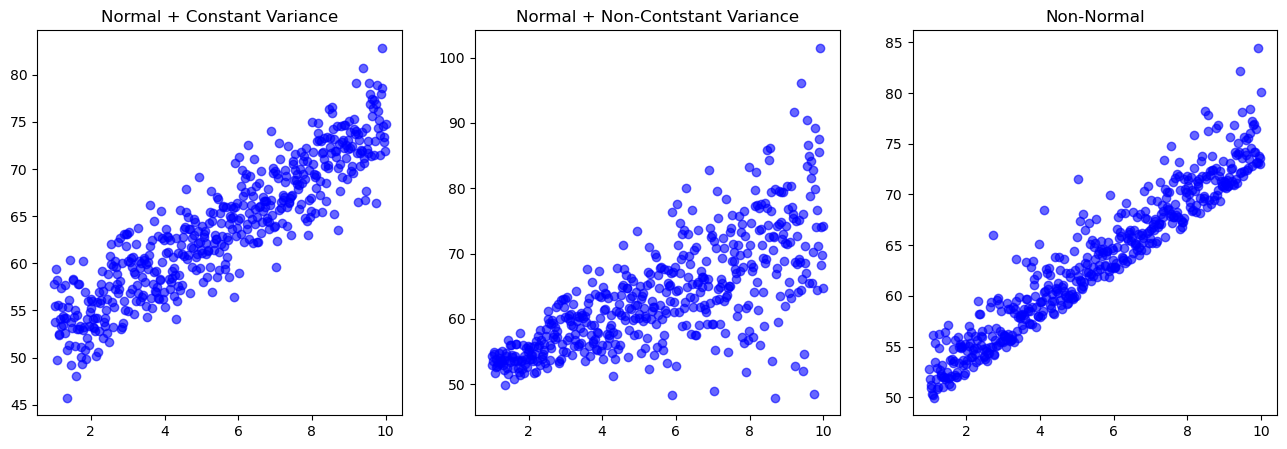

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
ax1.scatter(x1, y1, color='blue', alpha=0.6)
ax2.scatter(x3, y3, color='blue', alpha=0.6)
ax3.scatter(x4, y4, color='blue', alpha=0.6)
ax1.set_title("Normal + Constant Variance")
ax2.set_title("Normal + Non-Contstant Variance")
ax3.set_title("Non-Normal")
plt.show()

For checking the assumptions of normality homoscedasticity by directly analyzing the residuals, we now have to train a Linear Regression model for each of the three dataset. Using the scikit-learn implementation of Linear Regression, this is very easy to do:

In [13]:
X1 = x1.reshape(-1, 1)
X3 = x3.reshape(-1, 1)
X4 = x4.reshape(-1, 1)

model1 = LinearRegression().fit(X1, y1)
model3 = LinearRegression().fit(X3, y3)
model4 = LinearRegression().fit(X4, y4)

With the trained models, we can now get the predicted values for each input sample and calculate the respective residuals:

In [14]:
y1_pred = model1.predict(X1)
y3_pred = model3.predict(X3)
y4_pred = model4.predict(X4)

residuals1 = y1 - y1_pred
residuals3 = y3 - y3_pred
residuals4 = y4 - y4_pred

Again, we can use scatter plots to visualize the results. However, instead of plotting the data distribution like before, we now plot the predicted values against the residuals. In other words, the x-axis represents the predicted values, and the y-axis their respective residuals (i.e., the difference between the predicted value and the true value). The code cell below generates the scatter plots for all three datasets for a side-by-side comparison:

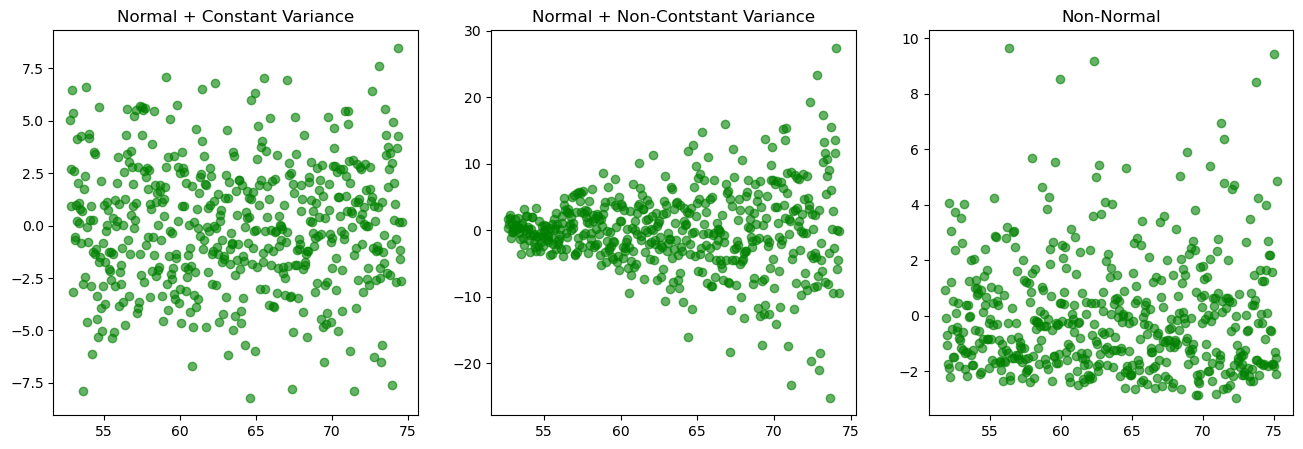

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
ax1.scatter(y1_pred, residuals1, color='green', alpha=0.6)
ax2.scatter(y3_pred, residuals3, color='green', alpha=0.6)
ax3.scatter(y4_pred, residuals4, color='green', alpha=0.6)
ax1.set_title("Normal + Constant Variance")
ax2.set_title("Normal + Non-Contstant Variance")
ax3.set_title("Non-Normal")
plt.show()

As shown in the left plot, if the residuals are normally distributed with a constant variance, the scatter plot, simply speaking, shows no discernable pattern: there are no cluster or lumps, no interesting shapes, and all points are equally distributed around $0$ with respect to the y-axis. If the residuals are normally distributed (middle plot), we are more likely to see certain patterns or shapes in the scatter plot. In this concrete case, the demo data was generated in such a way that the larger the value for $x_i$ the larger the variance when sampling $e_i$ for generating $y_i$. We can clearly see this relationship in the middle scatter plot. Lastly, the scatter plot on the right represents the results for the dataset with a non-normal distribution of error. Particularly notice that the points are no longer equally distributed around $0$ with respect to the y-axis. In practice this would mean that the model would systematically over- or underestimate the true output values.

Another way to check if residuals are (close to) normally distributed is the use of QQ plots. A **QQ plot (Quantile-Quantile plot)** is a powerful graphical tool used in statistics to assess how well a dataset matches a specific theoretical distribution or to compare two datasets' distributions. It is constructed by plotting the quantiles of the dataset against the quantiles of the reference distribution. If the two distributions are similar, the points on the plot will align closely along a 45-degree diagonal line. By visually comparing distributions, QQ plots offer an intuitive way to assess assumptions about data distribution. The primary purpose of a QQ plot is to identify deviations from the expected distribution. These deviations might indicate skewness, heavy tails, or other differences that can affect statistical analyses or modeling. For instance, when checking for normality, a QQ plot can reveal whether data deviates from the bell curve shape, such as exhibiting asymmetry or extreme values. Patterns in the plot can also provide clues about the nature of these differences, making it a versatile diagnostic tool.

For our use case we want to compare the distribution of the residuals with the Normal Distribution. The statsmodels library provides the method `qqplot()` for creating QQ plots. Notice in the code cell below the input parameter `dist=stats.norm` to specify that the distribution we want the residuals to compare with is the Normal Distribution. Again, we show the QQ plot for both dataset with and without a constant variance of the errors to see the differences in the respective QQ plots.

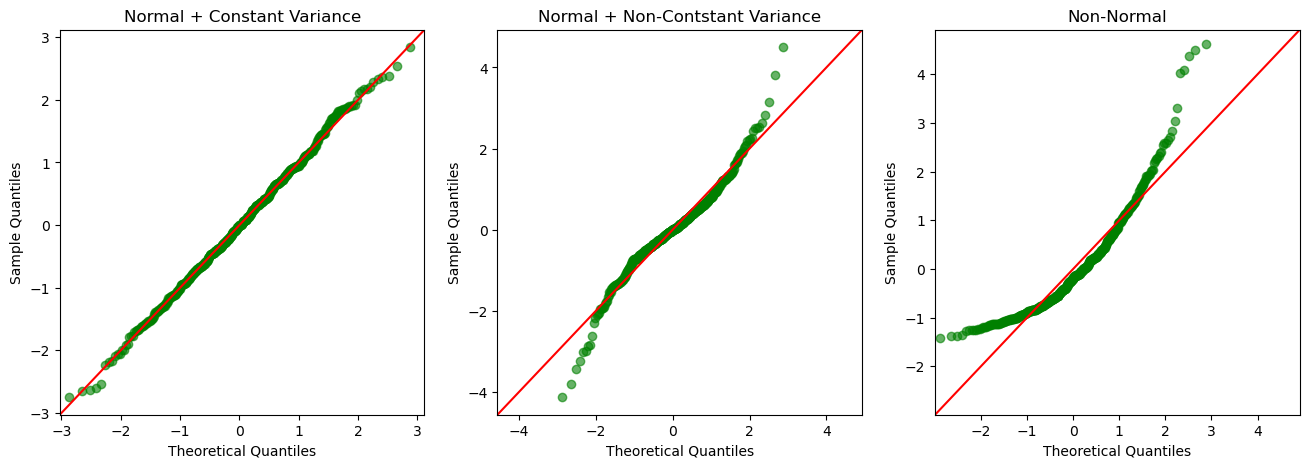

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sm.qqplot(residuals1, line='45', fit=True, dist=stats.norm, ax=ax1, markerfacecolor='g', markeredgecolor='g', alpha=0.6)
sm.qqplot(residuals3, line='45', fit=True, dist=stats.norm, ax=ax2, markerfacecolor='g', markeredgecolor='g', alpha=0.6)
sm.qqplot(residuals4, line='45', fit=True, dist=stats.norm, ax=ax3, markerfacecolor='g', markeredgecolor='g', alpha=0.6)
ax1.set_title("Normal + Constant Variance")
ax2.set_title("Normal + Non-Contstant Variance")
ax3.set_title("Non-Normal")
plt.show()

In the left QQ plot for the dataset with a constant error variance, all points align almost perfectly with the diagonal. This means that the distribution of the residuals (or errors) follows almost exactly Normal Distribution. In contrast, in the right QQ plot, we can see a significant deviation of the points from the diagonal. We can therefore conclude that the distribution of residuals do not follow a Normal Distribution.

### Assumption 3 (A3): Strict Exogeneity

#### Definitions
In the context of regression models, strict exogeneity refers to a condition where the residual or error term $e_i$ in the regression model is uncorrelated with *all* the independent variables (i.e., our input features) in the dataset for *all* data samples. Mathematically, this can be expressed as follows:

$$\large
E(e_i | \mathbf{X}) = E(e_i | \mathbf{x}_{1}, \mathbf{x}_{2}, \dots , \mathbf{x}_{n}) = 0
$$

where $n$ is the total number of data samples. In other words:

* **No Correlation between errors and features:** The error term has no systematic relationship with the predictors. This means the errors do not contain information about the predictors, implying that the predictors fully capture all relevant information about $y$, other than random noise.

* **No Feedback from $y$ to features:** The predictors are not influenced by the outcome $y$. This prevents issues such as reverse causality, where the dependent variable could impact one or more predictors, which would lead to correlation between the predictors and the error term.

* **Consistency of OLS Estimators:** Strict exogeneity ensures that the Ordinary Least Squares (OLS) estimators are consistent and unbiased. When this assumption holds, the estimators will converge to the true parameter values as the sample size increases.

Given the [Law of Total Expectations](https://en.wikipedia.org/wiki/Law_of_total_expectation), we get $E\left[E(e_i|\mathbf{X})  \right] = E(e_i) \Rightarrow E(e_i) = 0$, which is one of our core assumptions.

There a four main causes why the independent variables and errors might be correlated:

* Errors in variables
* Omitted variables
* Lagged dependent variables
* Simultaneous equations bias

In the following, we focus on the first two causes as they are the most relevant to the common regression problem based on cross-sectional data. (e.g., the prediction of house prices we have seen in the introductory notebook). In contrast, lagged dependent variables may occur in time series data (e.g., stock market prices) where the prices or returns $y_t$ of stocks on a day $t$ often depend on past returns $y_{t_1}$. Simultaneous equation bias occurs in econometric models when two or more equations are determined jointly, and one of the explanatory variables (independent variables) in an equation is also determined by the dependent variable of another equation in the system. Again, we ignore these two causes as they generally do not apply to most common regression problems for machine learning.

**Errors in variables.** Suppose we have a simple Linear Regression problem like our CSI example from the introductory notebook where we want to predict the height $y_i$ of a suspect based on the size of a shoe print $x_i$ we found on the crime scene (since we only have one feature, we can ignore the index $x_{i1}$ to keep it simple). This means that our Linear Regression model to estimate the true relationship between $x_i$ and $y_i$ is:

$$\large
y_i = w_{0} + w_{1}x_{i} + e_{i}
$$

To create a training dataset, we need to collect pairs of people's shoe print sizes and heights. Now, we also assume that we did a sloppy job measuring the size of shoe prints &mdash; this also includes the practical issue that the shoes of the same person might noticeably vary in size. Let's call those imprecise measurements $\tilde{x}_i$. Using $\tilde{x}_i$, our model for estimating the true relationship becomes:

$$\large
y_i = w_{0} + w_{1}\tilde{x}_{i} + \left[w_{1}(x_i - \tilde{x}_i) + e_i \right]
$$

since our imprecise measurements $\tilde{x}_i$ are the only ones we observe. This means what the model we now fit is:

$$\large
y_i = w_{0} + w_{1}\tilde{x}_{i} + v_{i}
$$

where $v_{i} = w_{1}(x_i - \tilde{x}_i) + e_i$. This means, that the model we train contains the difference $(x_i - \tilde{x}_i)$ in the error term. If there the correlation between the imprecise measurement and that difference is zero, i.e., $Corr(\tilde{x}_i, (x_i - \tilde{x}_i)) = 0$ &mdash; which in turn means that our sloppiness introduced a truly random error &mdash; this is not a problem. However, if $Corr(\tilde{x}_i, (x_i - \tilde{x}_i)) \neq 0$ (e.g., by systematically misaligning or misreading the scale when measuring the shoe print sizes), our estimation from $y_i = w_{0} + w_{1}\tilde{x}_{i} + v_{i}$ is biased and inconsistent compared to the estimation from the true relationship $y_i = w_{0} + w_{1}x_{i} + e_{i}$.

**Omitted variables.** Consider the Linear Regression problem with two input features (i.e., the independent variables) $x_{i1}$ and $x_{i2}$. Thus, our model to estimate the true relationship between the input features and the target output (i.e., the dependent variables) is:

$$\large
y_i = w_{0} + w_{1}x_{i1} + w_{1}x_{i2} + e_{i}
$$

Assuming the $e_i$ is a truly random error, $y_i$ is completely explained by $x_{i1}$ and $x_{i2}$ (and of course their weights $\mathbf{w}$). In other words, everything that is *not* explained by the model goes into the error. So, what happens if we consider only feature $x_{i1}$ to fit a Linear Regression model. Since $y_i$ is still influenced by both features but only explained by $x_{i1}$ in the model, feature $x_{i2}$ goes into the error. In other words, our model for estimating the true relationship becomes:

$$\large
y_i = w_{0} +w_{1}x_{i1} + (w_{2}x_{i2} + e_i)
$$

The model fit is therefore now:

$$\large
y_i = w_{0} + w_{1}x_{i} + v_{i}
$$

where $v_{i} = w_{2}x_{i2} + e_i$. Again, this is not a problem as long as $v_{i}$ a true random error, i.e., there is no correlation between the input feature $x_{i1}$ and the error $v_{i}$: $Corr(x_{i1}, v_{i}) = 0$. This intern requires that there is no correlation between $x_{i1}$ and $x_{i2}$, that is, $Corr(x_{i1}, x_{i2}) = 0$. However, in practice, the input features are typically not completely uncorrelated.

Consider the (oversimplified) Linear Regression task of predicting the price of a car based on the weight of the car ($x_{i1}$) power of its engine ($x_{i2}$). Both features $x_{i1}$ and $x_{i2}$ are likely to be correlated, as heavier cars typically have a larger engine with more power. This means that using only one of the features would result in a biased model. Let's say we would use only the weight $x_{i1}$. What would happen if we fit a Linear Regression model? The model would pick up the effects of both weight and the engine power in coefficient $w_{1}$ of for the weight (feature $x_{i1}$). In other words, the estimated weight $w_{1}$ would pick up the effect of $x_{i1}$ on $y_i$ *plus* the association between $x_{i1}$ and $x_{i2}$, and the effect of $x_{i2}$ on $y_{i}$.


#### Checking the Assumption

Unfortunately, there is no straightforward test &mdash; like a plot for A1 and A2 &mdash; to see if the assumption of strict exogeneity does hold. After all, in practice, we typically cannot know if all features have been collected correctly (*errors in variables*) or the training dataset does indeed contain all the features that influence the target variable (*omitted variables*). In fact, one can make the argument that strict exogeneity is never possible in practice since it is arbitrary likely that a training dataset does indeed include all the relevant features.  Take the example of predicting the price of cars from above. Even if we would include features such as a car's brand, model, range, number of seats, engine type (petrol/electric/hybrid), and so on, there might be many other factors that influence the price of the car. This can general economic trends, current policies (e.g., import tariffs), and others.

One might get an indication that the assumptions of strict exogeneity is (severely) violated if the trained model performed poorly despite the observation that other assumptions such as linearity (A1) as well as normality and homoscedasticity (A2) do hold. Simply speaking, the model *should* yield good predictions but it does not. A very common cause for this is that the model lacks important features to fully explain the output. But again, this is more an indication than a fool-proof way to check the assumption of strict exogeneity. In practice, we therefore have to ensure that our training dataset is of high-quality and capturing the most relevant features.

**Note:** There are ways to check for strict exogeneity which requires combining statistical tests (e.g., residual analysis, Hausman test) and careful theoretical reasoning about the data-generating process. If you suspect violations, one can consider using Instrumental Variables (IV) or Generalized Method of Moments (GMM) to obtain consistent estimates. However, this approach is rather complex and typically assumes a (very) small number of features. They are therefore beyond our scope here.

### Assumption 4 (A4): Low Multicollinearity

Multicollinearity refers to a situation in Linear Regression where two or more independent variables (i.e., features) are highly correlated. To give an example, let's go back to the task of predicting the price of a car based on the weight of the car ($x_{i1}$) power of its engine ($x_{i2}$). We already argued that both features $x_{i1}$ and $x_{i2}$ are likely to be correlated, as heavier cars typically have a larger engine with more power. To appreciate the problems that multicollinearity can cause, we first consider the case of **perfect multicollinearity**. Perfect multicollinearity occurs when one or more independent variables in a regression model are exact linear combinations of each other. For our car price example, let's assume that the power of a car's engine in Kilowatt is always a quarter of the car's weight in Kilogram &mdash; of course, this is not realistic and only used as an example. This means that $x_{i1} = 0.25 x_{i2}$. We can therefore rewrite the original model

$$\large
y_i = w_{0} + w_{1}x_{i1} + w_{2}x_{i2} + e_i
$$

to the following equation by incorporating this relationship between $x_{i1}$ and $x_{i2}$:

$$
\begin{align}
\large y_i &= \large w_{0} + w_{1}(0.25 x_{i2}) + w_{2}x_{i2} + e_i\\[0.5em]
&= \large w_{0} + (0.25 w_{1} + w_{2})x_{i2} + e_i\\[0.5em]
\end{align}
$$

This means that our model has conceptually collapsed to

$$\large
y_i = w_{0} + w^\prime x_{i2} + e_i
$$

with $w^\prime = 0.25 w_{1} + w_{2}$. Therefore, although we can estimate $w^\prime$ uniquely, there is no way to estimate $w_{1}$ and $w_{2}$ uniquely. $w^\prime = 0.25 w_{1} + w_{2}$ is one equation with two unknowns and there are infinite sets of solutions for a given value of $w^\prime$. In other words, the weights $w_{1}$ and $w_{2}$ are indeterminate and their standard errors are infinite, making it mathematically impossible to estimate their individual contributions to the dependent variable. For this reasons, perfect multicollinearity *must* be addressed before fitting an Linear Regression model.

If multicollinearity is less than perfect &mdash; also called **imperfect multicollinearity** or **high multicollinearity** &mdash; the weights will be determined. However, they are likely to possess large standard errors, which means the coefficient cannot be estimated with great passion or accuracy. This can undermine fitting a Linear Regression model in several ways:

* Small changes in the data can lead to large changes in the estimated weights; this makes it difficult to interpret the weights reliably, as they may not reflect the true relationship between the independent variables and the dependent variable.

* It becomes challenging to ascertain which independent variable is truly influencing the dependent variable; this can lead to misleading interpretations about the relationships among the variables.

* Multicollinearity can contribute to overfitting, where the model learns noise in the training data rather than the underlying relationship; this can negatively impact the model's performance on new, unseen data.

In summary, multicollinearity violates the assumption of independence among predictors in Linear Regression, leading to inflated standard errors, unstable estimates, and difficulties in interpretation and model validation.


#### Checking the Assumption

To see if a dataset shows signs of (high) multicollinearity, the most straightforward way is to calculate the [Pearson correlation coefficient](Pearson_correlation_coefficient) between all pairs of features. To give an example, let's first load a separate demo dataset from a file into a pandas DataFrame:

In [17]:
df_mc = pd.read_csv(demo_data_multicoll)

# Show the first entries of the DataFrame
df_mc.head()

,x1,x2,x3,x4,x5,y
0,0.496714,-0.173585,0.357787,-1.276229,0.541989,0.702740
1,-0.138264,-0.766306,0.560785,-1.261162,0.355263,-1.893866
2,0.647689,1.276507,1.083051,-0.606520,3.442609,13.734696
3,1.523030,3.005297,1.053802,-0.706882,5.112901,23.920814
4,-0.234153,-0.746669,-1.377669,1.701185,-3.502008,-11.390148


Using existing libraries, calculating the correlation between the features as well as the output variable is very simple. The `corr()` method in the pandas library is used to calculate the pairwise correlation of columns in a DataFrame. It measures the linear relationship between numerical columns, returning a correlation matrix.

In [18]:
correlation_matrix = df_mc.corr()

print(correlation_matrix)

          x1        x2        x3        x4        x5         y
x1  1.000000  0.914840  0.190840 -0.252812  0.740295  0.884503
x2  0.914840  1.000000  0.170268 -0.236759  0.785111  0.925800
x3  0.190840  0.170268  1.000000 -0.837603  0.743990  0.517800
x4 -0.252812 -0.236759 -0.837603  1.000000 -0.687005 -0.486640
x5  0.740295  0.785111  0.743990 -0.687005  1.000000  0.953232
y   0.884503  0.925800  0.517800 -0.486640  0.953232  1.000000


While the output of the code cell above shows all pairwise correlations, we can make the results more illustrative by plotting the correlation matrix as a heatmap where different colors reflect different values for the correlation coefficients. For convenience, we provide an auxiliary method `plot_correlation_matrix()` for this.

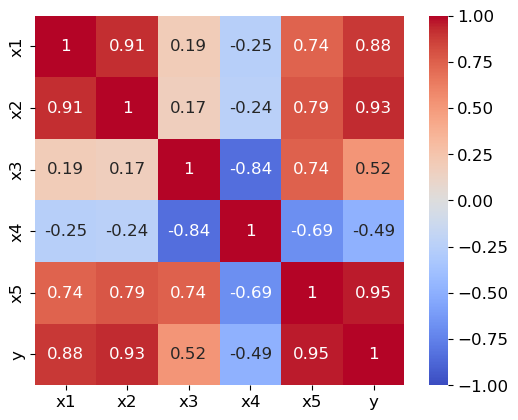

In [19]:
plot_correlation_matrix(correlation_matrix)

Several insights from this plot a worth mentioning:

* Of course, the diagonal of the correlation matrix show perfect correlations of $1$ since the diagonal represents the correlation between each variable with itself

* The features $x_1$, $x_3$, and $x_5$ are highly correlated (positively or negatively) with the target variable $y$. This indicates that these features are likely to be useful predictors when training or fitting a Linear Regression model over this dataset.

* Some features show a high pairwise correlation. For example, $x_1$ and $x_2$ have a high positive correlation of $0.91$, while $x_3$ and $x_4$ have a high negative correlation of $-0.84$. The higher the correlation between features, the higher risk of negative effects due to multicollinearity.

The main limitation of looking that correlation matrix is that it only shows *pairwise* correlations between the variables (i.e., features and target output). However, in principle, a feature might be a linear combination of multiple other features which would not show up in the correlation matrix. In the case of a perfect linear combination, one way to identify potential problems is to check the rank of the data matrix $X$. The rank of a matrix is the maximum number of linearly independent rows or columns in the matrix. In practical terms, the rank reveals how many of the rows or columns contain unique, non-redundant information. If the rank is less than the smaller dimension, some rows or columns are linear combinations of others.

Let's check this for our dataset. For this, we first need to extract the data matrix (and the label vector) from the pandas DataFrame.

In [20]:
X_mc = df_mc[['x1', 'x2', 'x3', 'x4', 'x5']].to_numpy()
y_mc = df_mc[['y']].to_numpy().squeeze()

The `matrix_rank()` method in the NumPy library is used to compute the rank of a matrix. It evaluates the number of linearly independent rows or columns in the matrix. This method is particularly useful in numerical computing, as it uses singular value decomposition (SVD) to determine the rank, which is a robust and reliable approach for handling numerical errors.

In [21]:
num_features = X_mc.shape[1]
num_ranks = np.linalg.matrix_rank(X_mc)

print(f"The rank of the data matrix with {num_features} is {num_ranks}")

The rank of the data matrix with 5 is 4


Since the rank of data matrix 4, i.e., one lower than the number of features, we can tell that one feature can be derived as a linear combination of some other features. In fact, this demo dataset was generated such that $x_5 = x_2 + 2x_3$. In real-world dataset &mdash; assuming when properly collected, curated, cleaned, preprocessed, etc. &mdash; such dependencies are very uncommon. This is particularly true for perfect linear combinations. If they are only close to perfect, the data matrix will have a full rank. Trying to identify if the linear combinations of multiple features may allow to "nearly" derive another feature is not commonly done in practice, at least in the context of machine learning and using Linear Regression to make predictions over data with many features. In real-world dataset, if there are no high pairwise correlations, the likelihood of high correlation between linear combinations of features is typically very low.

Apart from pairwise correlations, there are other methods to check if some data may show signs of high multicollinearity, incl. statistical test regarding the statistical significance of the weights, the examination of partial correlations, auxiliary regression models, using eigenvalues and condition index, or assessing the tolerance and variance inflation factor. However, a detailed discussion of those methods are beyond the scope of this notebook.

Whether multicollinearity is a problem and how much &mdash; ignoring perfect multicollinearity which is very rare in practice &mdash; depends on the exact task for a Linear Regression problem. It is commonly argued that if the sole purpose of regression analysis is prediction or forecasting, then multicollinearity is not a serious problem because the higher the $R^2$, the better the prediction. This assumes, however, that any unseen data for which we want to predict the target value must "look like" the training data. In other words, any unseen data must exhibit (more or less) the same multicollinearity characteristics. This also includes that multicollinearity tends to be less of a problem the larger the dataset is. If there is indeed a meaningful reason to address high/severe multicollinearity in a dataset, there are some rule-of-thumb procedures that can be applied, but which come with their own challenges and limitations, for example:

**Dropping a feature.** The  simplest way to remove or multicollinearity from the data is by removing a feature that shows a high correlation (positive or negative) with other features. The first problem is that there is no well-defined threshold for when pairwise correlation is too high. A commonly cited number is $0.8$. For our dataset above this means that we have two pairs of features to look at: $x_1$/$x_2$ and $x_3$/$x_4$. Since $x_2$ ($x_4$) shows a higher correlation with $y$, we could drop $x_1$ ($x_3$) to remove all severe multicollinearity. However, there are two obvious problems. Firstly, since the multicollinearity was not perfect, we do lose some information and our model is likely to perform worse regarding the quality of its prediction. And secondly, our task might require us to evaluate the importance of all the features.

**Using a-priori information.** Let's again consider our example task of predicting the price of a car based on its weight ($x_{i1}$) and engine power ($x_{i2}$):

$$\large
y_i = w_{0} + w_{1}x_{i1} + w_{2}x_{i2} + e_i
$$

But suppose now that we have the a-priori believe that $w_{2} = 0.2w_{1}$; that is, the rate of change of price of a car with respect to its engine power is $2/10$ the corresponding rate with respect its weight (we ignore if this is any realistic belief). We can then run the following regression:

$$
\begin{align}
\large y_i &= \large w_{0} + w_{1}x_{i1} +0.2w_{1}x_{i2} + e_i\\[0.5em]
&= \large w_{0} + w_{1}x_{i3} + e_i
\end{align}
$$

where $x_{i3} =x_{i1} + 0.2x_{i2}$. Once we obtain $w_{1}$, we can estimate $w_{2}$ from the postulated relationship between $w_{1}$ and $w_{2}$. Of course, it is not obvious where such a-priori information might come from. It could come from previous empirical work in which the collinearity problem happens to be less serious or from the relevant theory underlying the field of study. But again, relevant methods as well as other procedures to address multicollinearity are not the focus here.

**Side note:** Many implementations of Linear Regression provided by libraries are able to fit a model even in the presence of perfect multicollinearity in the data. To shows, we can use the `LinearRegression` implementation from the scikit-learn to fit a model using the demo dataset from above for which we know exhibits multicollinearity (i.e., the data matrix is not of full rank):

In [22]:
model_mc = LinearRegression().fit(X_mc, y_mc)

print(f"Bias weight w0: {model_mc.intercept_}")
print(f"feature weights: {model_mc.coef_}")

Bias weight w0: -0.06660304530454864
feature weights: [2.56506811 1.82128583 0.5053176  0.93715092 2.83192103]


Even if you execute the code cell above, the output will always be the same, although we said that perfect multicollinearity will cause (some of) the weights to be indeterminate as there are infinite solutions. This case, implementations such as used by scikit-learn under the hood, not only find the best weights $\mathbf{w}$ that minimize the MSE loss function but also minimize length of the weight vector $\mathbf{w}$, i.e., the set of weights that minimize the Euclidean 2-norm $\lVert \mathbf{w} \rVert_{2}$. It essentially puts a constraint on the absolute value of the individual weights and ensures that the overall solution is unique. Restricting the choice of weights $\mathbf{w}$ is common example of the general concept of [**regularization**](https://en.wikipedia.org/wiki/Regularization_(mathematics)).

### Assumption 5 (A5): No Autocorrelation of Residuals

#### Definition

The assumption of no autocorrelation in linear regression models means that the residuals (errors) are independent of each other. This implies that the error term for one observation should not be correlated with the error term for another. Autocorrelation often arises in time-series where the error at time $t$ might influence the error at time $t+1$, thus violating this assumption. In contrast, autocorrelation is not so prevalent in regular cross-sectional datasets. We therefore skip a more detailed discussion of this assumption.

#### Checking the Assumption

Autocorrelation can be detected using Autocorrelation Function (ACF) plots and Partial Autocorrelation Function (PACF) plots. A statistical test to detect the presence of autocorrelation is the [Durbin-Watson test](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic). But again, this is beyond the scope of this notebook as the focus is in cross-sectional data which typically does not contain any autocorrelation.


---

## Caveats

So far, we look at fundamental assumptions of Linear Regression models and how &mdash; to the extent it is meaningfully possible &mdash; they can be checked for any (severe) violation. In the following, we briefly cover two additional considerations for training Linear Regression models in practice. They are closely related to the core assumptions but worthwhile to explicitly look into.

### Caveat 1 (C1): Extreme Values

Extreme values in a regression dataset are data points that significantly differ from other observations in the dataset or deviate markedly from the expected behavior based on the regression model. These can manifest in various ways and are broadly categorized as outliers, leverage points, and influential points. Understanding and identifying these extreme values is critical, as they can disproportionately affect the results of a regression analysis. On can distinguish between three main types of extreme values:

* **Outliers:** These are data points where the dependent variable's value (i.e., the target output) is significantly different from the values predicted by the regression model. Outliers are identified by large residuals (the difference between observed and predicted values). Outliers may bias the coefficients, leading to a misrepresentation of the relationship between variables.

* **Leverage Points:** These are observations with extreme values for one or more independent variables (i.e., features), making them far from the center of the predictor space. High leverage points can have a disproportionate influence on the fitted regression line but are not necessarily outliers. High-leverage points can distort the regression line, even if their residuals are small.

* **Influential Points:** Influential points are extreme observations that significantly affect the regression model's fit. While not all leverage points or outliers are influential, a combination of the two often leads to an influential point. Influential points can undermine the stability of the model, making it less generalizable to new data.

We already saw an example of an outlier in Anscombe's Quartet at the beginning. Let's plot the relevant dataset here again:

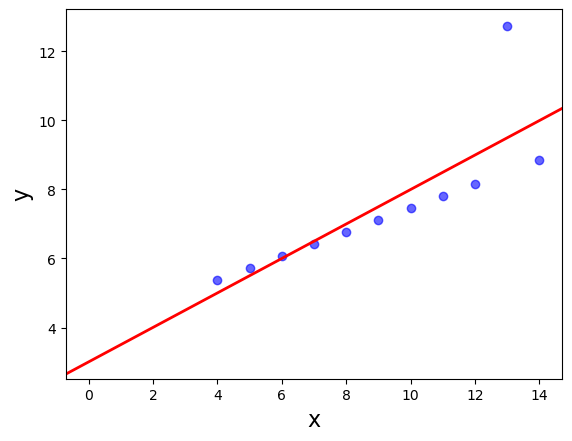

In [23]:
# Fit Linear Regression model to draw Regression Line
model_anscombe3 = LinearRegression().fit(x_anscombe.reshape(-1, 1), y_anscombe3)
w0_outlier, w1_outlier = model_anscombe3.intercept_, model_anscombe3.coef_[0]
            
# Plot dataset incl. regression line
plt.figure()
plt.scatter(x_anscombe, y_anscombe3, color='blue', alpha=0.6)
plt.gca().axline(xy1=(0, w0_outlier), slope=w1_outlier, color='r', lw=2)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

It is easy to see that without the outlier at $x=13$, the regression line would go directly through the remaining data points. However, this single data point alone can affect the location of the regression line quite noticeable. The reason why Linear Regression is rather sensitive to outliers is the use of the MSE loss function. Recall that the MSE:

$$\large
L_{MSE}(\hat{\mathbf{y}}, \mathbf{y}) = \sum_i^n (\hat{y}_i - y_i)^{2}
$$

calculate the *squared* residuals, i.e., the squared distances between the predicting and true values. Since outliers, by definition, have large residuals, they significantly affect the value of the MSE. Of course, the total amount of data points matters. The rarer the outliers are, the less of an effect they have on the model training.

Handling extreme values is often not trivial and depends on the cause of their occurrence. On the one hand, if extreme values are due to errors during data collection (e.g., in case of manual data entry, faulty sensors), extreme values should be identified (e.g., via statistical test using scatter plots as shown above) and then removed. However, extreme values can also be genuine and provide valuable insights about unusual observations or real-world phenomena. The key is to understand their nature and their impact on the model to make informed decisions about how to address them. If and how to deal with extreme values is typically a main part of the [Exploratory Data Analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis) and [Data Preprocessing](https://en.wikipedia.org/wiki/Data_preprocessing) phase when building machine learning models.

### Caveat 2 (C2): Interpolation vs Extrapolation

Consider the plot below showing a highly non-linear data distribution describing some true relationship between an input feature $x$ and a target variable $y$; in fact, this demo dataset was generated using the sine function with some added noise.

<img src="images/plots/linear-regression/sine-example-data-full.png" style="margin:auto;" alt="Decision Tree for Banking Example">

Since this dataset clearly violates the Linearity assumption, using a Linear Regression model to fit the data would be unsuitable. However, now let's assume that we were only able to collect a dataset for a limited range of feature values, say $3 \leq x \leq 7$. As a consequence, we would only have a partial view of the true relationship between $x$ and $y$. The plot below visualizes the dataset that we would now see; the very light blue data points indicate that data sample now missing from the dataset assuming the restricted range of $x$ values:

<img src="images/plots/linear-regression/sine-example-data-partial.png" style="margin:auto;" alt="Decision Tree for Banking Example">

This dataset now shows a very linear relationship between $x$ and $y$, thus arguably no longer violating the Linearity Assumption. Thus, training or fitting a Linear Regression model for this partial dataset is perfectly meaningful even though the model will not capture the true relationship between $x$ and $y$ for the full range of $x$ values. In fact, as long as we use our model to predict the output for unseen data points of the range $3 \leq x \leq 7$, the predictions are likely to be reasonably good.

This very simple example already highlights two important aspects we need to consider:

* **Dataset quality.** In practice, there is always the risk that a training dataset does not capture the full relationship between input features and the output value. Notice that this not only refers to the size of the dataset. For example, even if our partial dataset from above would have 10 times the amount of data points, if they are all in the range $3 \leq x \leq 7$ it still won't capture the full true relationship. In other words, we not only prefer large training datasets but also *representative* datasets &mdash; that is, datasets containing data points across all meaning feature values.

* **Careful extrapolation.** Regression models such as Linear Regression allow us to extrapolate target values. For our partial dataset above this means that we can make predictions for values of $x$ that are (much) smaller than $3$ and (much) larger than $7$. The models will happily return a prediction for any $x$ value. This includes that we can input feature values that are not meaningful at all. For example, consider the example of Linear Regression for predicting a car's price based on the car's weight and engine power. Once the model is trained, it will predict car prices even for negative values for the weight or the engine capacity. It is up to us to decide how much we can trust predictions for unseen data points that were not from the same distribution as the training data.

In short, as long as unseen dataset come from the same distribution &mdash; that is, for our example, all unseen data points have a $x$ value of range $3 \leq x \leq 7$ &mdash; a Linear Regression model is only *interpolating* the training data and the prediction are likely to be good. However, if we want to use the model to extrapolate the training data to make predictions for unseen data outside the distribution of the training, we have to carefully decide how meaningful the predictions are likely to be. This decision highly depends on the exact regression task and available dataset.

---

## Summary

Linear regression is a foundational statistical method used to model relationships between a dependent variable and one or more independent variables. Its utility depends on several key assumptions, which, when violated, can compromise the model's reliability and interpretability. Checking these assumptions ensures the validity of the model's results and its predictive power.

Adhering to these assumptions ensures the model's interpretability and the reliability of its predictions. When the assumptions are satisfied, the coefficient estimates are unbiased, and the model's predictions are consistent and efficient. Violations can lead to incorrect conclusions about relationships between variables, reduced predictive accuracy, and unreliable inferences. Thus, validating these assumptions is not just a theoretical exercise; it is a necessary step for building models that are not only statistically sound but also meaningful in real-world applications.